# **Step 1 : Importing the Libraries**

In [1]:
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Reshape,Dropout,GRU,LSTM,Bidirectional,TimeDistributed,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers,backend
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

# **Step 2 : Image Data Augumentation**

In [4]:
drive = os.getcwd()    # Get the current working directory (CWD)
classes = ['anger','disgust','fear','happy','neutral','sadness','surprise'] #
print(drive)

#source path to read Datasets
src_path_train = drive+"/KDEF"
src_path_test = drive+"/KDEFTEST"

# This is the augmentation configuration we will use for Training & Validation
train_datagen = ImageDataGenerator(
rescale=1 / 255.0,
rotation_range=20,
zoom_range=0.05,
shear_range=0.05,
horizontal_flip=True,
vertical_flip=True,
fill_mode="nearest",
brightness_range=[0.3,1],
validation_split=0.10)

# This is the augmentation configuration we will use for Testing
# only rescaling
test_datagen = ImageDataGenerator(rescale=1 / 255.0)


C:\Users\TelecomOne\Downloads\emotion final


# **Step 3 : Train Data Generator**

In [5]:
batch_size = 12 # iterator
dim = (184 , 184) # iterator

# this is a generator that will read pictures found in
# subfolders of 'KDEF/', and indefinitley generate 
# batches of augmented Image data
train_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='training',
shuffle=True,
seed=42
)
# This is a similar generator for validation data 
valid_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='validation',
shuffle=True,
seed=42
)
# This is a similar generator for Testing data 
test_generator = test_datagen.flow_from_directory(
directory=src_path_test,
target_size=dim,
color_mode="rgb",
batch_size=1,
class_mode=None,
shuffle=False,
seed=42
)

Found 444 images belonging to 7 classes.
Found 49 images belonging to 7 classes.
Found 81 images belonging to 7 classes.


# **Step 4 : Shape of the Input Datasets**

In [ ]:
#Input shape for training data
model_input_shape = (dim[0] , dim[1] ,3)
model_input = Input(shape=model_input_shape)

In [ ]:
print(model_input.shape)

(None, 184, 184, 3)


# **Step 5 : Novel VGG 16 + Bi-LSTM Model for KDEF Datasets**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# load the model
# include the 3 fully-connected layers as False
# pre-training on ImageNet
base_model = VGG16(input_shape = (184, 184, 3),include_top = False,weights = 'imagenet')

In [ ]:
# making for each layer Trainable as False
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
print(base_model.output)
# The model so far outputs 4D feature Maps (Height,Width,Features) 
x = layers.Reshape((-1,512))(base_model.output) # Reshape 4D feature maps into 3D feature
x = layers.Bidirectional(LSTM(150, return_sequences=True))(x)
x = layers.Dropout(0.4)(x)
x = layers.Bidirectional(LSTM(10))(x)

x = layers.Flatten()(x)  # This Converts our 3D feature maps to 1D feature vectors 


x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(7, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

# On top of it we stick two fully-connected layers. We end the model with a single unit and a sigmoid activation, 
# which is perfect for binary classification. To go with it we will also use the binary_crossentropy a loss to train our model
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 184, 184, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 184, 184, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 184, 184, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 92, 92, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 92, 92, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 92, 92, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 46, 46, 128)       0   

# **Step 6 :  Saving Model to Storage**

In [ ]:
# Monitor Validation Loss and Restore The Best weights 
early_stop_complete_cnn = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2,mode='auto', baseline=None, restore_best_weights=True)

# always save your best weights after training or during training 
checkpoint_complete_cnn = keras.callbacks.ModelCheckpoint(drive+'/vgg16_kdef.h5',monitor='val_loss',verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# **Step 7 : Training the Model**

In [ ]:
with tf.device('/device:GPU:1'):
    history = model.fit_generator(train_generator,
                               validation_data = train_generator,
                               callbacks=[early_stop_complete_cnn, checkpoint_complete_cnn],
                               epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.1532
Epoch 00001: val_loss improved from inf to 0.49518, saving model to /content/drive/MyDrive/vgg16_kdef.h5
37/37 [==============================] - 25s 450ms/step - loss: 0.5751 - accuracy: 0.1532 - val_loss: 0.4952 - val_accuracy: 0.1486
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.1104
Epoch 00002: val_loss improved from 0.49518 to 0.42788, saving model to /content/drive/MyDrive/vgg16_kdef.h5
37/37 [==============================] - 15s 404ms/step - loss: 0.4593 - accuracy: 0.1104 - val_loss: 0.4279 - val_accuracy: 0.1419
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.1284
Epoch 00003: val_loss improved from 0.42788 to 0.41209, saving model to /content/drive/MyDrive/vgg16_kdef.h5
37/37 [==============================] - 15s 404ms/step - loss: 0.4210 - accuracy: 0.1284 - val_loss: 0.4121 - val_accuracy: 0.1

# **Step 8 : Training and Validation Graph**

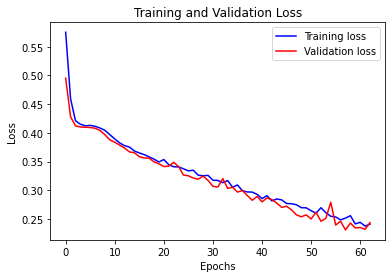

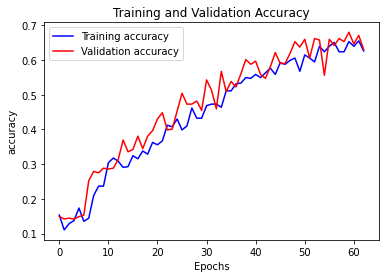

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]  #Training Loss Array
    val_loss = history.history["val_loss"] #Validation Loss Array
    accuracy = history.history["accuracy"]  #Training Accuracy Array
    val_accuracy = history.history["val_accuracy"]  #Validation Accuracy Array
    epochs = range(len(loss)) #Plot total epochs
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


# **Step 9 : Prediction for Test images**

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
Y_pred = model.predict_generator(test_generator, 981) #Predict Emotions on Test Images with number for test images taken
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred)) #Printing confusion Matrix
print('Classification Report')
target_names = ['anger','disgust','fear','happy','neutral','sadness','surprise'] 
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) # Printing classification report


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 5  0  1  0  0  4  0]
 [ 0 10  0  1  0  2  0]
 [ 1  0  4  2  4  0  1]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 2  0  0  1  0  8  0]
 [ 0  0  0  0  1  0 11]]
Classification Report
              precision    recall  f1-score   support

       anger       0.62      0.50      0.56        10
     disgust       1.00      0.77      0.87        13
        fear       0.80      0.33      0.47        12
       happy       0.73      1.00      0.85        11
     neutral       0.71      1.00      0.83        12
     sadness       0.57      0.73      0.64        11
    surprise       0.92      0.92      0.92        12

    accuracy                           0.75        81
   macro avg       0.76      0.75      0.73        81
weighted avg       0.77      0.75      0.74        81



# **Loading the KDEF Datasets Trained Model**

In [ ]:
kdef_model = tf.keras.models.load_model(drive+'/vgg16_kdef.h5')

# **Reading** Images From Src Path

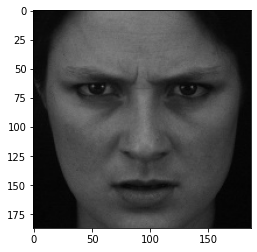

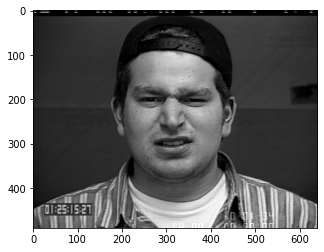

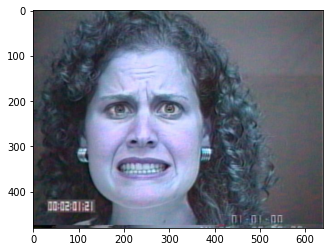

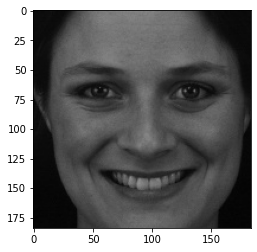

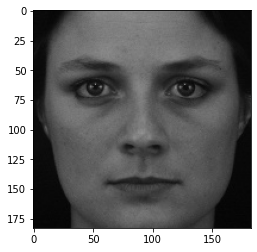

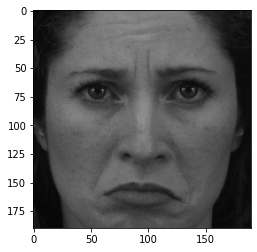

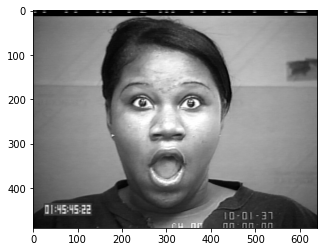

In [ ]:
anger = cv2.imread(drive+'/content/drive/MyDrive/AN_01.png')
contempt = cv2.imread(drive+'/content/drive/MyDrive/contempt.png')
disgust = cv2.imread(drive+'/content/drive/MyDrive/S134_008_00000013.png')
fear = cv2.imread(drive+'/content/drive/MyDrive/fear.png')
happy = cv2.imread(drive+'/content/drive/MyDrive/HA_01.png')
neutral = cv2.imread(drive+'/content/drive/MyDrive/NE_01.png')

sadness = cv2.imread(drive+'/content/drive/MyDrive/SA_011.png')
surprise = cv2.imread(drive+'/content/drive/MyDrive/surprise.png')

img_array = [anger,disgust,fear,happy,neutral,sadness,surprise];

for img in img_array:
    plt.imshow(img)
    plt.show()

# CV2 Cascade **Classifier**

In [ ]:
face_detector = cv2.CascadeClassifier(drive+"/haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(drive+"/haarcascade_eye.xml")

# **Convert all input images into Gray  Scale**

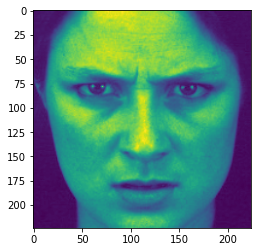

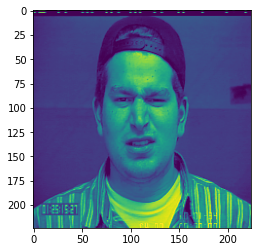

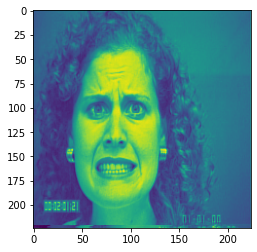

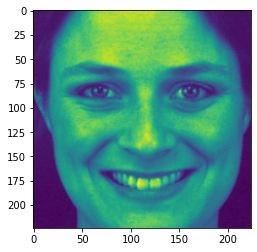

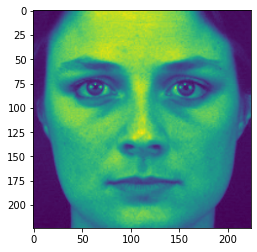

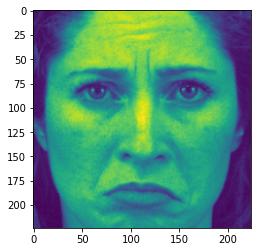

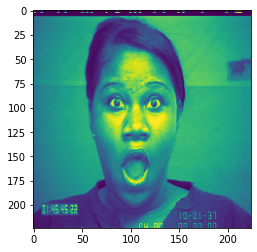

In [ ]:
gray_img = []
for img in img_array:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (224,224))
    gray_img.append(gray)
    plt.imshow(gray)
    plt.show()

# **Using KDEF Trained Model Predicting the Emotion on Face in all Images**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[0.53264385 0.0700407  0.05836967 0.00210346 0.15884322 0.16281271
  0.01248587]]
anger


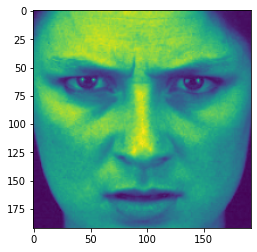

[[1.21426292e-01 6.89738750e-01 3.05363722e-02 1.16108306e-01
  3.12604010e-03 5.03163449e-02 3.03793699e-04]]
disgust


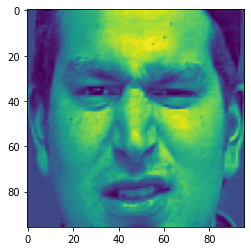

[[0.05838332 0.00594494 0.34672007 0.01326779 0.1439888  0.34423077
  0.04413249]]
fear


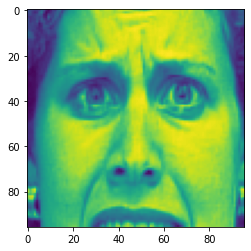

[[1.9388353e-02 1.4148921e-01 6.6738084e-02 8.1416708e-01 2.5778790e-03
  2.8122285e-02 4.6082877e-04]]
happy


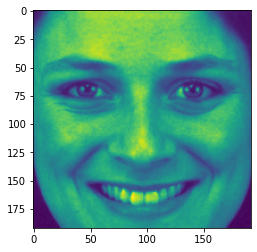

[[0.09672841 0.00175286 0.1285298  0.00266329 0.4266507  0.11061178
  0.12026364]]
neutral


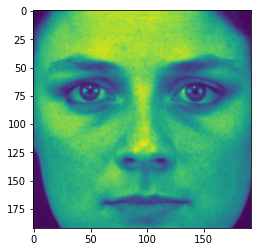

[[0.17130965 0.00417999 0.13207284 0.00555258 0.3047275  0.20139338
  0.03770928]]
neutral


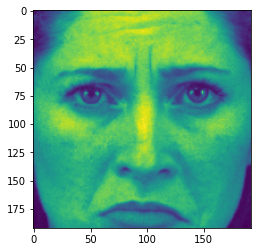

[[0.01116141 0.00189605 0.24684821 0.01237663 0.09892892 0.02958807
  0.70916283]]
surprise


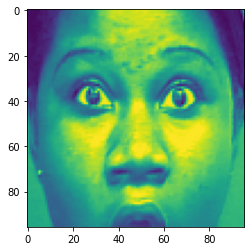

In [ ]:
face_img = []
for gray_roi_img in gray_img:
    faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)      #Opencv Harcascade Face Detector
    # print(len(faces)) 
    if(len(faces) == 0):
        gray_roi_img = cv2.resize(gray_roi_img, (224,224))           # if face not detected, resize it to 224
        faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)   # after resize again detect face using opencv harcascade filter    
    face_x, face_y, face_w, face_h = faces[0]                       # face locations
    face_new_img = gray_roi_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]  #crop image on face locations
    final_img = cv2.resize(face_new_img, (184,184))                 #reshape into model input shape and make it to 3D image
    final_img = np.expand_dims(final_img, axis=0)                   #Expanding dimensions by adding axis=0, 
    final_img = final_img/255.0;
    #     final_img = np.expand_dims(final_img ,axis=-1)
    final_img = np.repeat(final_img[:, :, :,np.newaxis], 3, axis=-1)  # reshape 3D to 4D

    final_img = np.float32(final_img)[...,:3]
    #     print(final_img.shape)
    Y_pred = kdef_model.predict_generator(final_img,1)              # Predict Emotion on faces in images
    print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['anger','disgust','fear','happy','neutral','sadness','surprise']

    print(target_names[y_pred[0]])
    plt.imshow(face_new_img)
    plt.show()

# **Conv2D + Maxpooling2D + Bi-LSTM MODEL FOR CK+48 Datasets**

In [6]:
drive = os.getcwd()    # Get the current working directory (CWD)
#source path to read Datasets
src_path_train = drive+"/CK+48"
src_path_test = drive+"/test"

# **Step 1: Image Data Augumentation**

In [7]:
# This is the augmentation configuration we will use for Training & Validation
train_datagen = ImageDataGenerator(
rescale=1 / 255.0,
rotation_range=20,
zoom_range=0.05,
shear_range=0.05,
horizontal_flip=True,
vertical_flip=True,
fill_mode="nearest",
brightness_range=[0.3,1],
validation_split=0.10)

# This is the augmentation configuration we will use for Testing
# only rescaling
test_datagen = ImageDataGenerator(rescale=1 / 255.0)


# **Step 2 : Reading Images with Image Data  Generator**

In [8]:
batch_size = 12
#CK+48
dim = (48 , 48)

# this is a generator that will read pictures found in
# subfolders of 'KDEF/', and indefinitley generate 
# batches of augmented Image data
train_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='training',
shuffle=True,
seed=42
)
# This is a similar generator for validation data 
valid_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='validation',
shuffle=True,
seed=42
)
# This is a similar generator for Testing data 
test_generator = test_datagen.flow_from_directory(
directory=src_path_test,
target_size=dim,
color_mode="rgb",
batch_size=1,
class_mode=None,
shuffle=False,
seed=42
)

Found 1425 images belonging to 7 classes.
Found 153 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


# **Step 3 : Input Shape of the Images**

In [ ]:
#Input shape for training data
model_input_shape = (dim[0] , dim[1] ,3)
model_input = Input(shape=model_input_shape)
print(model_input.shape)

(None, 48, 48, 3)


# **Step 4 :  Conv2D + MaxPooling2D + Bi-LSTM Model**

In [ ]:
def emotion_recognition(input_shape):

    X_input = Input(input_shape)

    X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)


    X = MaxPooling2D((2,2))(X)

    X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

 

    X = MaxPooling2D((2,2))(X)

    # The model so far outputs 4D feature Maps (Height,Width,Features) 
    X = Reshape((-1,128))(X) # Reshape 4D feature maps into 3D feature
    X = Bidirectional(LSTM(50, return_sequences=True))(X)
    X = Dropout(0.4)(X)
    X = Bidirectional(LSTM(10))(X)

    X = Flatten()(X)  # This Converts our 3D feature maps to 1D feature vectors 
    X = Dense(200, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(7, activation = 'softmax')(X)

    model = Model(inputs=X_input, outputs=X)

    return model

In [ ]:
model = emotion_recognition((48,48,3))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                             

In [ ]:
# On top of it we stick two fully-connected layers. We end the model with a single unit and a softmax activation, 
# which is perfect for binary classification. To go with it we will also use the categorical_crossentropy a loss to train our model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# **Step 5 : Saving Model to Local Storage**

In [ ]:
# Monitor Validation Loss and Restore The Best weights 
early_stop_complete_cnn = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2,mode='auto', baseline=None, restore_best_weights=True)

# always save your best weights after training or during training 
checkpoint_complete_cnn = keras.callbacks.ModelCheckpoint(drive+'/transferlearn_ck48.h5',monitor='val_loss',verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# **Step 6 : Training Model**

In [ ]:
with tf.device('/device:GPU:1'):
    history = model.fit_generator(train_generator,
                               validation_data = train_generator,
                               callbacks=[early_stop_complete_cnn, checkpoint_complete_cnn],
                               epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 1.9423 - accuracy: 0.1663
Epoch 00001: val_loss improved from inf to 1.94484, saving model to /content/drive/MyDrive/transferlearn_ck48.h5
119/119 [==============================] - 249s 2s/step - loss: 1.9423 - accuracy: 0.1663 - val_loss: 1.9448 - val_accuracy: 0.1389
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 1.9140 - accuracy: 0.2365
Epoch 00002: val_loss improved from 1.94484 to 1.94215, saving model to /content/drive/MyDrive/transferlearn_ck48.h5
119/119 [==============================] - 47s 393ms/step - loss: 1.9140 - accuracy: 0.2365 - val_loss: 1.9422 - val_accuracy: 0.1579
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 1.8650 - accuracy: 0.2674
Epoch 00003: val_loss improved from 1.94215 to 1.92875, saving model to /content/drive/MyDrive/transferlearn_ck48.h5
119/119 [==============================] - 47s 392ms/step - loss: 1.8650 - accuracy: 0.2674 - va

# **Step 7 :  Training & Validation Accuracy**

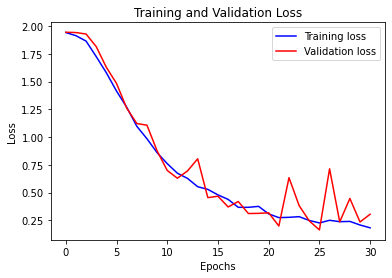

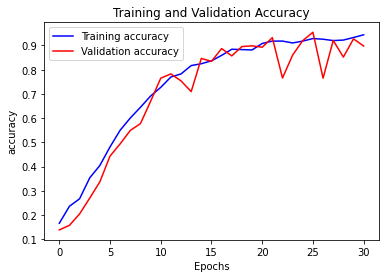

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]  #Training Loss Array
    val_loss = history.history["val_loss"]  #Validation Loss Array
    accuracy = history.history["accuracy"]  #Training Accuracy Array
    val_accuracy = history.history["val_accuracy"]  #Validation Accuracy Array
    epochs = range(len(loss)) #Plot total epochs
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


# **Step 8 : Prediction For Test Images**

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
Y_pred = model.predict_generator(test_generator, 166) #Predict Emotions on Test Images with number for test images taken
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred)) #Printing confusion Matrix
print('Classification Report')
target_names = ['anger','contempt','disgust','fear','happy','sadness','surprise']
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) # Printing classification report


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[30  0  0  0  0  0  0]
 [ 1 24  0  3  0  2  0]
 [ 0  0 36  0  0  0  0]
 [ 0  0  0 18  2  0  0]
 [ 0  0  0  0 20  0  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0  3 17]]
Classification Report
              precision    recall  f1-score   support

       anger       0.97      1.00      0.98        30
    contempt       1.00      0.80      0.89        30
     disgust       1.00      1.00      1.00        36
        fear       0.86      0.90      0.88        20
       happy       0.91      1.00      0.95        20
     sadness       0.67      1.00      0.80        10
    surprise       1.00      0.85      0.92        20

    accuracy                           0.93       166
   macro avg       0.91      0.94      0.92       166
weighted avg       0.95      0.93      0.93       166



Prediction 

# **Prediction of Emotions Using Conv2D + Maxpooling2D + Bi-LSTM Model for CK+48 Dataset**

In [ ]:
trans_model = tf.keras.models.load_model(drive+'/transferlearn_ck48.h5')

# **Reading Images from Path**

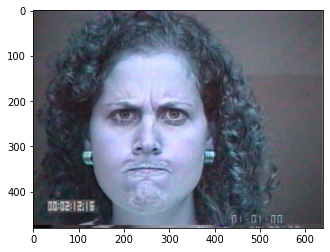

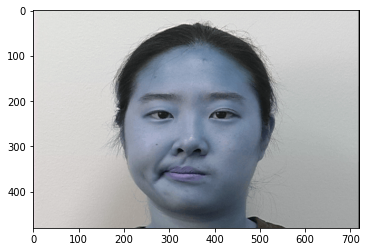

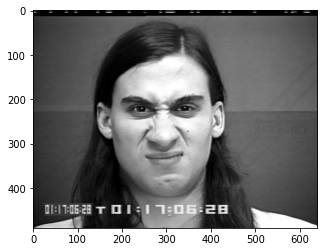

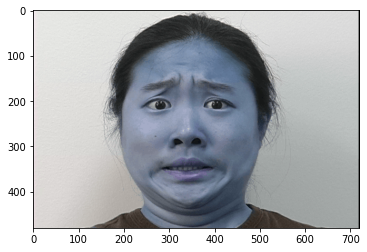

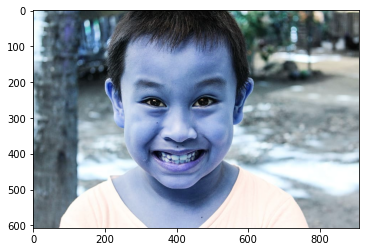

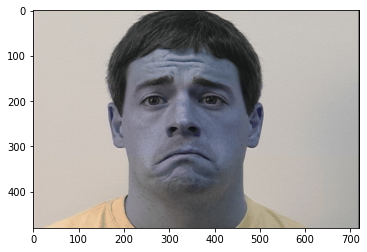

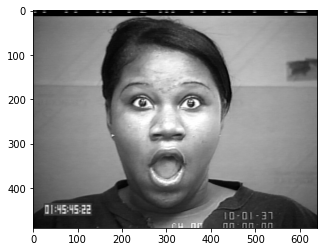

In [ ]:
anger = cv2.imread(drive+'/content/drive/MyDrive/anger4.png')
contempt = cv2.imread(drive+'/content/drive/MyDrive/contempt3.png')
disgust = cv2.imread(drive+'/content/drive/MyDrive/disgust5.png')
fear = cv2.imread(drive+'/content/drive/MyDrive/fear7.png')
happy = cv2.imread(drive+'/content/drive/MyDrive/happy.jpg')
neutral = cv2.imread(drive+'/content/drive/MyDrive/NE_01.png')

sadness = cv2.imread(drive+'/content/drive/MyDrive/sadness.png')
surprise = cv2.imread(drive+'/content/drive/MyDrive/surprise.png')

img_array = [anger,contempt,disgust,fear,happy,sadness,surprise];

for img in img_array:
    plt.imshow(img)
    plt.show()

In [ ]:
face_detector = cv2.CascadeClassifier(drive+"/haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(drive+"/haarcascade_eye.xml")

## **Convert All Images to Grayscale**

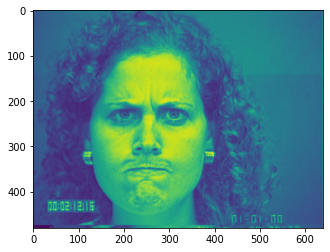

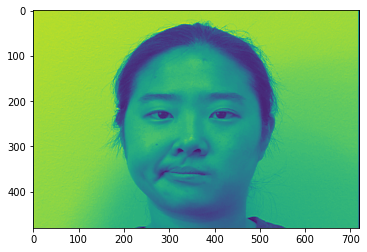

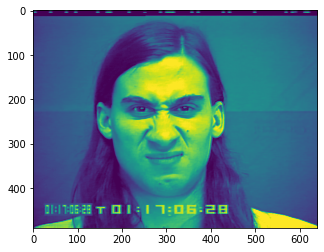

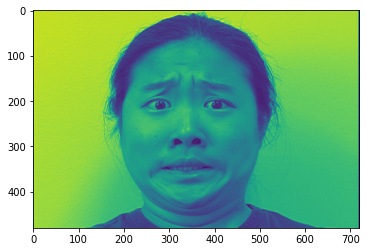

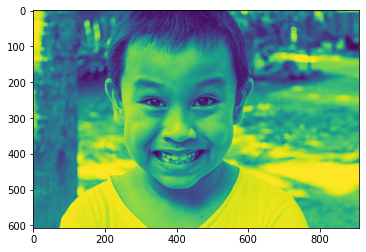

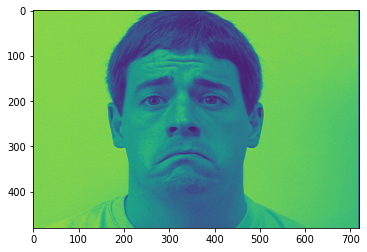

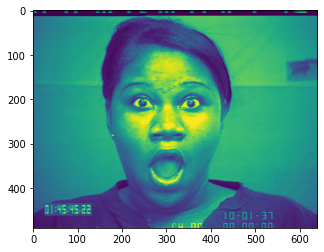

In [ ]:
gray_img = []
for img in img_array:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print(img.name)
    # gray = cv2.resize(gray, (224,224))
    gray_img.append(gray)
    plt.imshow(gray)
    plt.show()

# **Predicting the Emotion on Face in Images**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[6.1027706e-01 4.3672388e-03 1.2158828e-02 2.7526956e-04 2.1726888e-04
  3.7169111e-01 1.0132267e-03]]
anger


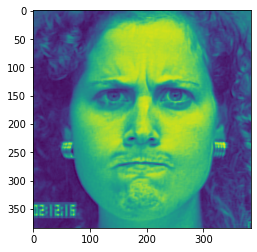

[[1.2817218e-02 9.2628509e-01 1.0290201e-03 8.2390988e-03 1.2834072e-04
  5.0736282e-02 7.6504162e-04]]
contempt


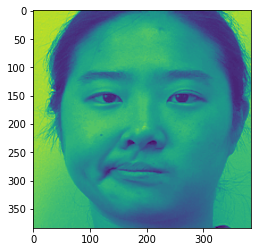

[[0.13576554 0.03855318 0.4298705  0.0322517  0.088429   0.20071921
  0.07441093]]
disgust


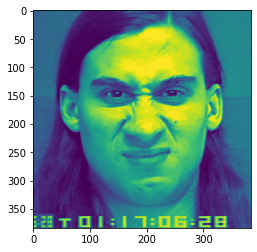

[[1.0557383e-03 2.4240239e-01 4.0539997e-04 7.1369088e-01 8.4570370e-04
  2.5094643e-02 1.6505232e-02]]
fear


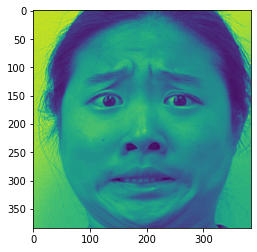

[[1.7458145e-03 2.1865827e-03 7.5378753e-02 7.0643634e-02 8.4869576e-01
  4.1322401e-04 9.3628955e-04]]
happy


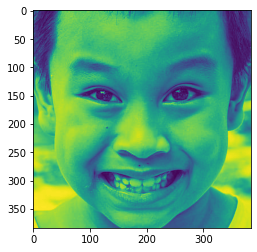

[[5.7146292e-02 1.7768752e-02 1.3479466e-03 4.8885663e-04 4.6585585e-05
  9.2250293e-01 6.9863821e-04]]
sadness


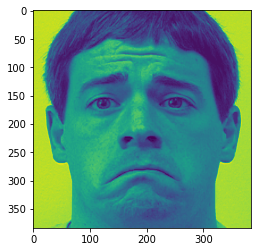

[[7.0940814e-04 2.0526996e-02 2.5467770e-04 2.7590208e-02 2.1865703e-04
  5.8520671e-02 8.9217943e-01]]
surprise


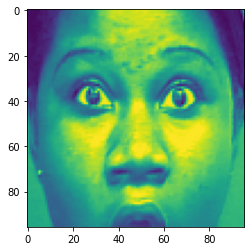

In [ ]:
face_img = []
for gray_roi_img in gray_img:
    faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)    #Opencv Harcascade Face Detector
    # print(len(faces)) 
    if(len(faces) == 0):
        gray_roi_img = cv2.resize(gray_roi_img, (224,224))         # if face not detected, resize it to 224
        faces = face_detector.detectMultiScale(gray_roi_img, 2, 5) # after resize again detect face using opencv harcascade filter 
    face_x, face_y, face_w, face_h = faces[0]                     # face locations
    face_new_img = gray_roi_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)] #crop Image to face located
    final_img = cv2.resize(face_new_img, (48,48))                 #reshape into model input shape and make it to 3D image
    final_img = np.expand_dims(final_img, axis=0)                 #Expanding dimensions by adding axis=0,
    final_img = final_img/255.0;
    #     final_img = np.expand_dims(final_img ,axis=-1)
    final_img = np.repeat(final_img[:, :, :,np.newaxis], 3, axis=-1)  # reshape 3D to 4D

    final_img = np.float32(final_img)[...,:3]
    #     print(final_img.shape)
    Y_pred = trans_model.predict_generator(final_img,1)            # Predict Emotion on faces in images
    print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

    print(target_names[y_pred[0]])
    plt.imshow(face_new_img)
    plt.show()

# **Jaffe Data Set**

# **Importing Libraries**

In [ ]:
from tensorflow.keras import utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from keras.layers import BatchNormalization
import os
from sklearn.metrics import classification_report
# src_path_train = "/Jaffe"
# src_path_test = "/content/drive/MyDrive/jaffetest"

# **Reading Images from path & Separates each Images based on their Classes**

In [ ]:
drive = os.getcwd()    # Get the current working directory (CWD)

#source path to read Datasets
data_path = "/jaffebase"
data_dir_list = os.listdir(data_path)


names = ['happy', 'sad', 'surprise', 'angry', 'disgust', 'fear', 'neutral']
labels = []
img_data_list=[]

img_list=os.listdir(data_path) #read all images from directory
print ('Loaded the images of dataset-'+'{}'.format(data_path))
del img_list[0]
del img_list[0]
for img in img_list:
    input_img=cv2.imread(data_path + '/'+ img ) #cv2 read images from path
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)  #convert color images into gray scale
    input_img_resize=cv2.resize(input_img,(48,48))  #resize each image with 48*48
    img_data_list.append(input_img_resize)  #append images into array
    if 'AN' in img.split('.')[1]:           #split if image name contains AN append label with angry
        labels.append(names.index('angry'))
    elif 'HA' in img.split('.')[1]:         #split if image name contains HA append label with happy
        labels.append(names.index('happy'))
    elif 'SA' in img.split('.')[1]:         #split if image name contains SA append label with sad
        labels.append(names.index('sad'))
    elif 'NE' in img.split('.')[1]:          #split if image name contains NE append label with neutral
        labels.append(names.index('neutral'))
    elif 'SU' in img.split('.')[1]:           #split if image name contains SU append label with Surprise
        labels.append(names.index('surprise'))
    elif 'DI' in img.split('.')[1]:          #split if image name contains DI append label with disgust
        labels.append(names.index('disgust'))
    elif 'FE' in img.split('.')[1]:        #split if image name contains FE append label with fear
        labels.append(names.index('fear'))
print(len(labels))
# print(labels)
        
img_data = np.array(img_data_list)    
img_data = img_data.astype('float32')
img_data = img_data/255
X = img_data
num_classes = len(names)
Y = utils.to_categorical(labels, len(names))

Loaded the images of dataset-/content/drive/MyDrive/jaffebase
227
[2, 3, 2, 3, 4, 0, 5, 4, 2, 3, 0, 4, 2, 5, 5, 1, 0, 6, 2, 0, 1, 0, 5, 6, 1, 1, 5, 6, 6, 6, 1, 3, 5, 6, 4, 5, 3, 2, 4, 1, 0, 4, 3, 0, 1, 0, 2, 2, 3, 1, 2, 4, 4, 4, 5, 4, 0, 0, 0, 3, 6, 5, 4, 3, 5, 3, 3, 3, 5, 6, 1, 0, 5, 0, 2, 4, 2, 4, 4, 1, 6, 6, 3, 0, 5, 2, 6, 5, 1, 3, 6, 2, 0, 4, 2, 2, 1, 6, 2, 0, 4, 4, 3, 0, 1, 3, 3, 3, 5, 1, 6, 2, 1, 2, 4, 5, 2, 6, 4, 5, 3, 6, 1, 1, 3, 1, 2, 1, 1, 1, 2, 5, 3, 3, 3, 5, 2, 0, 5, 3, 6, 0, 6, 5, 4, 6, 4, 4, 4, 3, 6, 4, 0, 0, 0, 4, 2, 5, 6, 1, 3, 6, 3, 5, 6, 1, 5, 0, 5, 2, 1, 1, 5, 0, 2, 6, 0, 1, 0, 0, 4, 4, 3, 3, 1, 2, 2, 6, 6, 4, 5, 6, 6, 5, 5, 5, 0, 2, 3, 1, 0, 6, 1, 2, 0, 0, 5, 1, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [ ]:
# def getLabel(id):
#     return names[id]

# **Split Images into Train & Test**

In [ ]:
#split X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.10, shuffle=True, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], 48, 48, 1)) #reshape xtrain input shape with 48*48
X_test = np.reshape(X_test, (X_test.shape[0], 48, 48, 1))  #reshape xtest input shape with 48*48

print(X_train.shape)
print(X_test.shape)

(204, 48, 48, 1)
(23, 48, 48, 1)


# **Conv2d + Maxpooling + Bi-LSTM Model**

In [ ]:
input_shape=(48,48,1)

model = Sequential()

model.add(Conv2D(6,(6,6), input_shape=input_shape))
model.add(Conv2D(2,(2,2)))
model.add(Conv2D(4,(2,2)))
model.add(MaxPooling2D())
model.add(Conv2D(4,(2,2)))

# The model so far outputs 4D feature Maps (Height,Width,Features) 
model.add(Reshape((-1,4))) # Reshape 4D feature maps into 3D feature
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
# model.add(GRU(32)) 
# model.add(Dropout(0.2)) 
model.add(Dense(units = 1))
# model.add(Bidirectional(LSTM(40, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(10)))
model.add(Flatten())  # This Converts our 3D feature maps to 1D feature vectors 
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 43, 43, 6)         222       
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 2)         50        
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 4)         36        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 4)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 19, 19, 4)         68        
                                                                 
 reshape_2 (Reshape)         (None, 361, 4)            0         
                                                      

In [ ]:
# On top of it we stick two fully-connected layers. We end the model with a single unit and a softmax activation, 
# which is perfect for binary classification. To go with it we will also use the categorical_crossentropy a loss to train our model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Saving Model**

In [ ]:
# Monitor Validation Loss and Restore The Best weights 
early_stop_complete_cnn = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2,mode='auto', baseline=None, restore_best_weights=True)

# always save your best weights after training or during training 
checkpoint_complete_cnn = keras.callbacks.ModelCheckpoint(drive+'/jaffe_model.h5',monitor='val_loss',verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
#slicing both xtrain and ytrain
tr_ds1 = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2)

# **Training Datasets**

In [ ]:
with tf.device('/device:GPU:1'):
    history = model.fit_generator(tr_ds1,
                               validation_data = tr_ds1,
                               callbacks=[early_stop_complete_cnn, checkpoint_complete_cnn],
                               epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 1.9548 - accuracy: 0.1471
Epoch 00001: val_loss improved from inf to 1.94332, saving model to /content/drive/MyDrive/jaffe_model.h5
102/102 [==============================] - 37s 308ms/step - loss: 1.9548 - accuracy: 0.1471 - val_loss: 1.9433 - val_accuracy: 0.1373
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.1569
Epoch 00002: val_loss improved from 1.94332 to 1.94273, saving model to /content/drive/MyDrive/jaffe_model.h5
102/102 [==============================] - 30s 291ms/step - loss: 1.9506 - accuracy: 0.1569 - val_loss: 1.9427 - val_accuracy: 0.2108
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 1.9465 - accuracy: 0.1863
Epoch 00003: val_loss improved from 1.94273 to 1.94125, saving model to /content/drive/MyDrive/jaffe_model.h5
102/102 [==============================] - 29s 290ms/step - loss: 1.9465 - accuracy: 0.1863 - val_loss: 1.9413 - va

# **Training & Validation Accuracy**

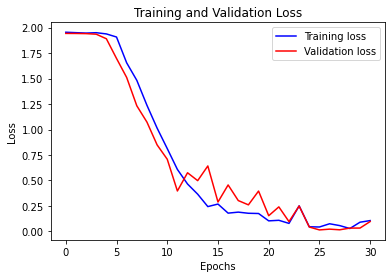

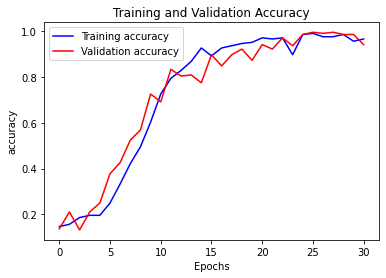

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"] #Training Loss Array
    val_loss = history.history["val_loss"] #Validation Loss Array
    accuracy = history.history["accuracy"] #Training Accuracy Array
    val_accuracy = history.history["val_accuracy"]  #Validation Accuracy Array
    epochs = range(len(loss)) #Plot total epochs
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


# **Prediction for Test Images**

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1) #emotion predict for test images

In [ ]:
y_pred = utils.to_categorical(y_pred, num_classes) #choose name from classes array

In [ ]:
print(classification_report(y_test, y_pred, target_names=names)) #classification report

              precision    recall  f1-score   support

       happy       0.60      0.75      0.67         4
         sad       0.50      0.50      0.50         4
    surprise       1.00      0.50      0.67         2
       angry       0.60      1.00      0.75         3
     disgust       1.00      1.00      1.00         1
        fear       0.80      0.80      0.80         5
     neutral       1.00      0.50      0.67         4

   micro avg       0.70      0.70      0.70        23
   macro avg       0.79      0.72      0.72        23
weighted avg       0.75      0.70      0.69        23
 samples avg       0.70      0.70      0.70        23



In [ ]:
trans_model = tf.keras.models.load_model(drive+'/jaffe_model.h5')

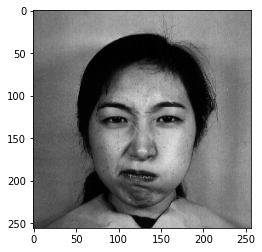

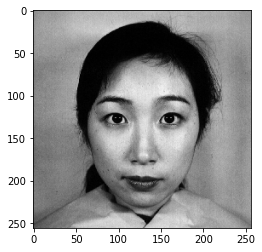

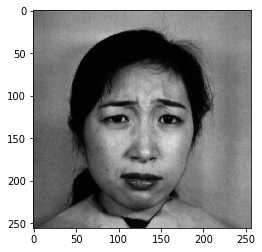

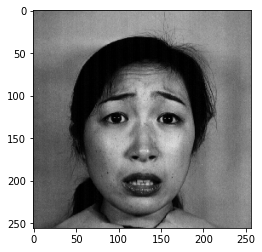

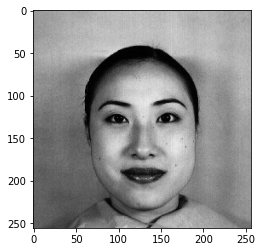

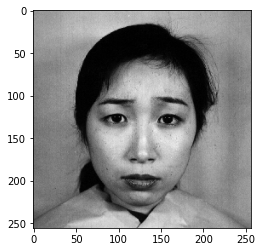

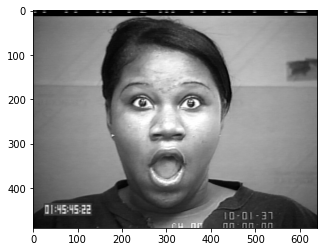

In [ ]:
anger = cv2.imread(drive+'/jaffebase/KA.AN1.39.tiff')
contempt = cv2.imread(drive+'/content/drive/MyDrive/contempt3.png')
disgust = cv2.imread(drive+'/jaffebase/KA.DI1.42.tiff')
fear = cv2.imread(drive+'/jaffebase/KA.FE1.45.tiff')
happy = cv2.imread(drive+'/jaffebase/KR.HA1.74.tiff')
neutral = cv2.imread(drive+'/jaffebase/KA.NE1.26.tiff')

sadness = cv2.imread(drive+'/jaffebase/KA.SA1.33.tiff')
surprise = cv2.imread(drive+'/content/drive/MyDrive/surprise.png')

img_array = [anger,neutral,disgust,fear,happy,sadness,surprise];

for img in img_array:
    plt.imshow(img)
    plt.show()

In [ ]:
face_detector = cv2.CascadeClassifier(drive+"/haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(drive+"/haarcascade_eye.xml")

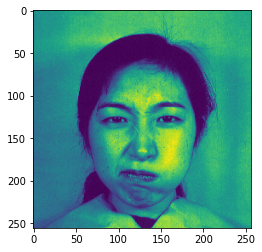

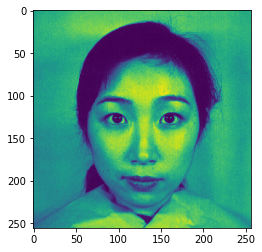

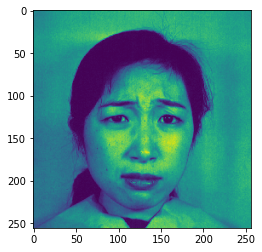

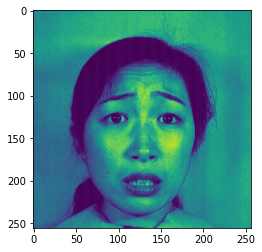

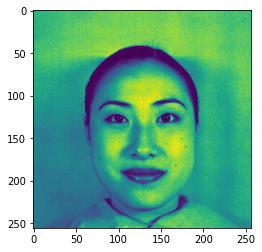

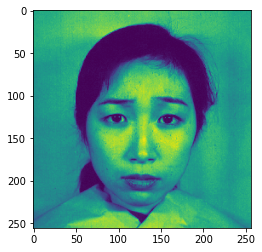

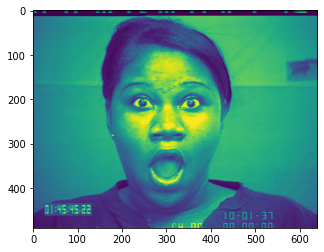

In [ ]:
gray_img = []
for img in img_array:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print(img.name)
    # gray = cv2.resize(gray, (224,224))
    gray_img.append(gray)
    plt.imshow(gray)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[5.5167351e-13 6.9135976e-06 5.9234933e-03 8.6716497e-01 1.2532553e-01
  1.4541395e-09 1.5790274e-03]]
angry


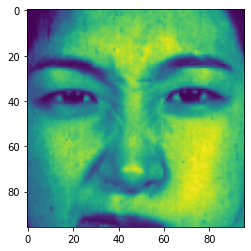

[[1.70864841e-12 1.04586206e-07 2.88180187e-02 1.13657677e-07
  6.52971328e-04 9.70501661e-01 2.70830606e-05]]
fear


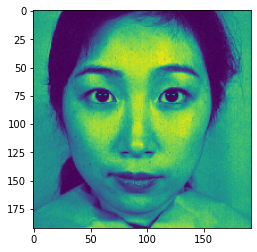

[[7.5541115e-01 2.2150802e-04 2.4273276e-01 2.4537260e-07 4.5563934e-06
  2.1996981e-04 1.4098274e-03]]
happy


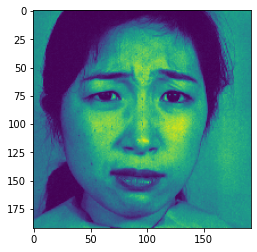

[[2.0033793e-10 1.9994810e-05 4.0448440e-11 3.9067050e-03 2.7608055e-01
  7.0063835e-01 1.9354332e-02]]
fear


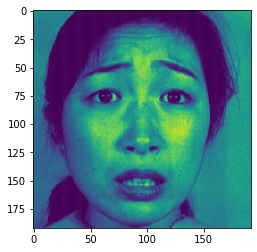

[[9.9979812e-01 1.8972974e-08 2.7939445e-08 1.3387718e-14 2.5384860e-16
  9.7186375e-09 2.0190966e-04]]
happy


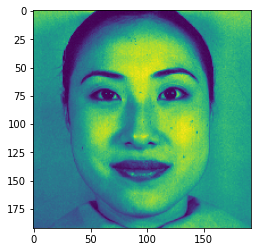

[[2.6682948e-05 8.9965779e-01 2.2953635e-03 5.3663235e-02 1.2325400e-02
  1.0686674e-06 3.2030515e-02]]
sad


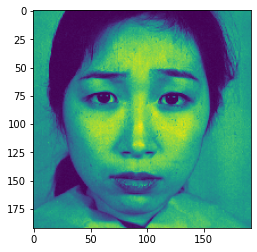

[[5.6961943e-07 5.5381133e-06 9.7188729e-01 1.9309107e-06 3.5895705e-06
  2.6488567e-02 1.6124693e-03]]
surprise


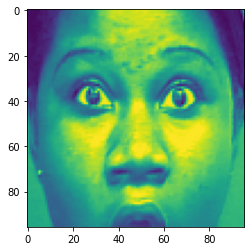

In [ ]:
face_img = []
for gray_roi_img in gray_img:
    faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)        #Opencv Harcascade Face Detector
    # print(len(faces)) 
    if(len(faces) == 0):
        gray_roi_img = cv2.resize(gray_roi_img, (224,224))             # if face not detected, resize it to 224
        faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)     # after resize again detect face using opencv harcascade filter  
    face_x, face_y, face_w, face_h = faces[0]                         # face locations
    face_new_img = gray_roi_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]   #crop image into face location
    final_img = cv2.resize(face_new_img, (48,48))                    #reshape into model input shape and make it to 3D image
    final_img = np.expand_dims(final_img, axis=0)                    #Expanding dimensions by adding axis=0, 
    final_img = final_img/255.0;
    #     final_img = np.expand_dims(final_img ,axis=-1)
    # final_img = np.repeat(final_img[:, :, :,np.newaxis], 3, axis=-1)

    # final_img = np.float32(final_img)[...,:3]
    # print(final_img.shape)
    Y_pred = trans_model.predict_generator(final_img,1)      # Predict Emotion on faces in images
    print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['happy', 'sad', 'surprise', 'angry', 'disgust', 'fear', 'neutral']

    print(target_names[y_pred[0]])
    plt.imshow(face_new_img)
    plt.show()